In [14]:
import pandas as pd
import numpy as np

# from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import datapath

import re
import nltk
from nltk.tokenize import word_tokenize
from razdel import tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import pymorphy2

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrleg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrleg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
news1234 = pd.read_csv("articles.csv")
news1234['title'][0]

'Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как сообщаетnпресс-службаnармейцев, такое решение было единогласно принято на первом заседании совета клуба. Основной функцией этого органа будет обсуждение текущего состояния, планирование и утверждение стратегии развития клуба на ближайшую перспективу.nnВ состав совета вошли:nГеоргий Полтавченкоn(полномочный представитель президента в Центральном федеральном округе),nАлексей Седовn(генерал-полковник, начальник службы по защите конституционного строя и борьбе с терроризмомnФСБ РФn),nАлександр Новакn(заместитель министра финансов РФ),nВячеслав Полтавцевn(заместитель генерального директора, руководитель блока по взаимодействию с органами власти, социальной и корпоративной политикиnГМК «Норильский никель»n),nЛеонид Исаковичn(генеральный директор ООО «УК «Спортивные проекты»),nОльга Плешаковаn(генеральный директорn«Трансаэро»n),nАлександр Провоторовn, (генеральный директорnОАО «Ростелеком»n), А

In [9]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [10]:
users = pd.read_csv("users_articles.csv")
print(news.shape)
users.head(3)

(27000, 2)


,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [24]:
stopword_ru = stopwords.words('russian')

morph = pymorphy2.MorphAnalyzer()

In [25]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [26]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
#     text = text.strip('\n').strip('\r').strip('\t')
#     text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n|n", ' ', text)
#     text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
#     print(text)
    
    tokens = list(word_tokenize(text))
#     print(tokens)
#     words = [_.text for _ in tokens]
    tokens = [w for w in tokens if w not in stopword_ru]
#     print(tokens)
    
    return " ".join(tokens)

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [27]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-26-c5503b3260cd>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 2min 16s


In [28]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 46s


In [29]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [30]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = news['title'].values

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)

In [31]:
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [32]:
LdaModel?

In [33]:
%%time
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 49.5 s


In [34]:
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [35]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это']


[(1, 0.23340224),
 (3, 0.460647),
 (6, 0.08808667),
 (7, 0.06875713),
 (12, 0.042472795),
 (21, 0.042829324),
 (22, 0.045995906)]

In [36]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic, words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: суд год тело ракета расчёт млн иск
topic_1: человек который год это также свой обнаружить
topic_2: научный исследование год земля взрыв поверхность который
topic_3: это журнал статья который очень человек налог
topic_4: это доллар эксперт метод высокий уровень который
topic_5: ребёнок это семья школа свой родитель экономика
topic_6: район станция ракета км высота статья житель
topic_7: пациент обращение сенатор акционер армения макаров расчёт
topic_8: погибнуть город террорист результат человек боевик который
topic_9: пенсия турция турецкий пресссекретарить препарат песок путин
topic_10: земля сотрудник источник который писать год эксперимент
topic_11: банк ст ук пища фсб еда начальник
topic_12: год который компания проект новый время это
topic_13: путин президент температура египет лаборатория палата владимир
topic_14: японский золото таиланд диск сценарий хороший тепло
topic_15: физика вицепремьер медицина озеро операция лётчик фаза
topic_16: россия год который российский сш

In [37]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [38]:
# Получаем матрицу. Строки - определенные документы и их вероятность принадлежности к определенному топику
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.000000,0.024579,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.0,0.135907,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.035048,0.0
1,4896,0.055059,0.000000,0.921340,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0
2,4897,0.000000,0.233538,0.000000,0.460516,0.00000,0.000000,0.088027,0.068833,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.00000,0.042807,0.045996,0.000000,0.0
3,4898,0.000000,0.000000,0.049272,0.551427,0.12777,0.097244,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.16399,0.000000,0.000000,0.000000,0.0
4,4899,0.000000,0.692196,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.282180,0.0


In [39]:
# Датафрейм пользователей. Строки - пользователь + прочитанные им статьи
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [40]:
# Формируем словарь статей (документов)
# Ключ - айди документа/статьи
# Значение - нампай эррей вероятностей принадлежности статьи к определенному классу
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [71]:
doc_dict[323329]

array([0.        , 0.        , 0.        , 0.2780447 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.16052704, 0.        ,
       0.        , 0.54001403, 0.01186579, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [78]:
user_articles_list = users['articles'].iloc[33]

# Функция формирует "вектор пользователя"
# Берутся статьи которые читал пользователь (их вектора вероятностей принадлежности к топикам/классам)
# По эррею векторов берется СРЕДНЕЕ
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [79]:
# output of the function on above
get_user_embedding(user_articles_list)

array([0.02627648, 0.13942139, 0.0040865 , 0.09787297, 0.03494797,
       0.00523399, 0.        , 0.        , 0.        , 0.012188  ,
       0.05635018, 0.        , 0.05007516, 0.09879773, 0.        ,
       0.01503734, 0.32449752, 0.00197763, 0.05107757, 0.        ,
       0.        , 0.        , 0.04051537, 0.01876297, 0.00746298])

In [80]:
#users['articles'].iloc[33]

In [45]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

In [46]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.007470,0.144171,0.105743,0.019741,0.000000,0.047145,0.032547,0.00000,0.015242,...,0.000000,0.184118,0.006070,0.011559,0.019758,0.048810,0.000000,0.026664,0.018428,0.009502
1,u108690,0.004038,0.176255,0.023223,0.071715,0.008074,0.045168,0.007268,0.00000,0.000000,...,0.000000,0.409862,0.003678,0.000000,0.000000,0.028253,0.012157,0.031046,0.011389,0.021667
2,u108339,0.014525,0.183388,0.035502,0.023808,0.005673,0.011724,0.064132,0.00429,0.046574,...,0.029541,0.274347,0.000000,0.011357,0.007203,0.008791,0.014822,0.014315,0.004529,0.030818


In [47]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [48]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.007470,0.144171,0.105743,0.019741,0.000000,0.047145,0.032547,0.00000,0.015242,...,0.184118,0.006070,0.011559,0.019758,0.048810,0.000000,0.026664,0.018428,0.009502,0
1,u108690,0.004038,0.176255,0.023223,0.071715,0.008074,0.045168,0.007268,0.00000,0.000000,...,0.409862,0.003678,0.000000,0.000000,0.028253,0.012157,0.031046,0.011389,0.021667,1
2,u108339,0.014525,0.183388,0.035502,0.023808,0.005673,0.011724,0.064132,0.00429,0.046574,...,0.274347,0.000000,0.011357,0.007203,0.008791,0.014822,0.014315,0.004529,0.030818,1


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [50]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [51]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [52]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.15397285, 0.16094233, 0.37850074, 0.14467424, 0.02505752,
       0.09789165, 0.09694854, 0.02295113, 0.08063339, 0.08376734])

In [53]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [54]:
import itertools

In [55]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.228340, F-Score=0.632, Precision=0.552, Recall=0.739


In [56]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1608  147]
 [  65  180]]


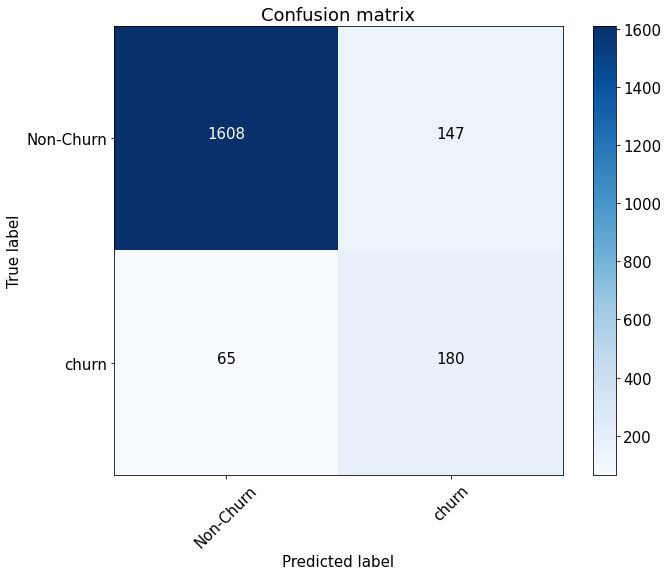

In [57]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [58]:
roc_auc_score(y_test, preds)

0.9339217396360252

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [89]:
user_articles_list = users['articles'].iloc[33]

# Функция формирует "вектор пользователя"
# Берутся статьи которые читал пользователь (их вектора вероятностей принадлежности к топикам/классам)
# По эррею векторов берется СРЕДНЕЕ
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [90]:
# output of the function on above
get_user_embedding(user_articles_list)

array([0.02627648, 0.13942139, 0.0040865 , 0.09787297, 0.03494797,
       0.00523399, 0.        , 0.        , 0.        , 0.012188  ,
       0.05635018, 0.        , 0.05007516, 0.09879773, 0.        ,
       0.01503734, 0.32449752, 0.00197763, 0.05107757, 0.        ,
       0.        , 0.        , 0.04051537, 0.01876297, 0.00746298])

In [87]:
user_articles_list = users['articles'].iloc[33]

# Функция формирует "вектор пользователя"
# Берутся статьи которые читал пользователь (их вектора вероятностей принадлежности к топикам/классам)
# По эррею векторов берется МЕДИАНА
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [88]:
# output of the function on above
get_user_embedding_median(user_articles_list)

array([0.        , 0.02790494, 0.        , 0.04912344, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03039914, 0.        , 0.        , 0.02869115, 0.        ,
       0.        , 0.30485344, 0.        , 0.02159803, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

В отличии от среднего, мы получили больше нулей, так как медиана лежит в середине отсортированного распределения. Вполне вероятно, что она вернула нам нули в те топики, статьи к которым чаще всего НЕ относились (вероятность принадлежности большинства статей к этим топикам была нулевая)  
  
Часто медиану считают более репрезентативной, чем среднее и не зря :)

In [83]:
user_articles_list = users['articles'].iloc[33]

# Функция формирует "вектор пользователя"
# Берутся статьи которые читал пользователь (их вектора вероятностей принадлежности к топикам/классам)
# По эррею векторов берется МАКСИМУМ
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [84]:
# output of the function on above
get_user_embedding_max(user_articles_list)

array([0.11234461, 0.66108805, 0.02451897, 0.2780447 , 0.16124094,
       0.03140391, 0.        , 0.        , 0.        , 0.07312802,
       0.17703418, 0.        , 0.25457969, 0.37487707, 0.        ,
       0.0673277 , 0.54498482, 0.01186579, 0.16209367, 0.        ,
       0.        , 0.        , 0.21813004, 0.07366431, 0.0447779 ])

Максимум вернул нам самый "жирный" вектор вероятностей принадлежности статьи к топикам. Честно говоря, не особо понимаю, как это было посчитано, ибо все вектора должны равняться единицам